# ARIMA

/home/kokatte/Documents/IDC/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/kokatte/Documents/IDC/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/kokatte/Documents/IDC/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/kokatte/Documents/IDC/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/kokatte/Documents/IDC/.venv/lib/python3.10/site-packages/statsmodels/tsa/b

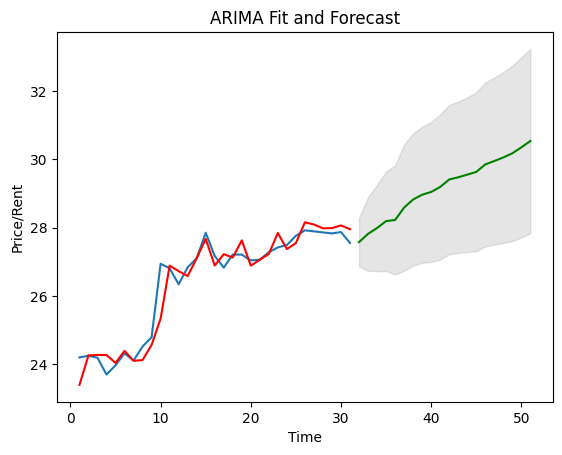

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA



# fit model
class arima():

    def __init__(self):
        return


    # "In reality, you want to conduct time series cross-validation to select the best model" (params)
    def fit_model(self, data, params=(10,1,1), steps=20):
        '''
            give 1 areas quarterly data 

            returns something
            fit 
            forecast = prediction of i steps
            errors
        '''
        series = pd.Series(data)
        self.series = series
        self.params = params
        self.steps = steps


        model = ARIMA(series, order=params, trend='t') 
        fit_model = model.fit()
        forecast = fit_model.get_forecast(steps=steps) # statsmodels obj

        # results
        self.prediction = forecast.predicted_mean
        self.fit = fit_model.fittedvalues
        self.ci = forecast.conf_int()

        return self.fit, self.prediction, self.ci
    
    def plot(self):
        idxs = range(len(self.series.index))
        forecast_idxs = pd.RangeIndex(start=len(idxs), stop=len(idxs) + self.steps)

        # data and fit with predictions
        plt.plot(idxs[1:], self.series[1:], label='Data')
        plt.plot(idxs[1:], self.fit[1:], color='red', label='ARIMA Fit')
        plt.plot(forecast_idxs, self.prediction, color='green', label=f'ARIMA Forecast ({self.steps} steps)')

        # onfidence intervals 
        ci = self.ci
        plt.fill_between(forecast_idxs, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.2, label='Confidence Interval')

        # legend
        plt.xlabel('Time')
        plt.ylabel('Price/Rent')
        plt.title('ARIMA Fit and Forecast')
        # plt.legend()

        plt.show()
        return 


data=pd.read_csv("merged_data.csv")
a = arima()
# data_1Q = data.loc[(data['Huoneluku']=='Yksiöt') & (data['Posti']==140)]['Neliöhinta (EUR/m2)']    #['Neliövuokra (eur/m2)']
data_1Q = data.loc[(data['Huoneluku']=='Yksiöt') & (data['Posti']==140)]['Neliövuokra (eur/m2)'] 
a.fit_model(data_1Q)
a.plot()
